**med-prj1-stats-jnb.ipynb**: Jupyter notebook template provided in support of the course *Modeling of Earth System Data* (Fall 2022, course instructor: Joachim Vogt).

# Statistical Concepts in Earth Data Modeling

In this project, temperature records from the *CDC (Climate Data Center)* of the *DWD (Deutscher Wetterdienst)* are used to demonstrate the statistical techniques presented in the first course chapter. Monthly distributions of hourly air temperature time series are studied, average daily variations are constructed, and sample statistics are computed using methods for normally distributed data as well as bootstrap techniques.

Imports: NumPy, matplotlib.pyplot, scipy.stats, seaborn.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

## Preparation

Consult the CDC website (https://www.dwd.de/EN/climate_environment/cdc/cdc_node_en.html, https://opendata.dwd.de/) and familiarize with its *terms of use* (https://www.dwd.de/EN/service/copyright/copyright_node.html). 

See https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature/historical/
for the hourly temperature measurements used in this project.

The functions ``TimeStr2Int()`` and ``TimeInt2Str()`` convert times from string format to integers and vice versa.

In [18]:
def TimeStr2Int(TimeStr,StrFormat='yyyymmddhh'):
    '''
    Convert TimeStr(ing) to Int(eger) year,month,day,hour.
    Supported string formats: yyyymmddhh,dd.mm.yyyy-hh:mm.
    '''
    if StrFormat=='yyyymmddhh':
        year = np.int(TimeStr[0:4])
        month = np.int(TimeStr[4:6])
        day = np.int(TimeStr[6:8])
        hour = np.int(TimeStr[8:10])
    elif StrFormat=='dd.mm.yyyy-hh:mm':
        year = np.int(TimeStr[6:10])
        month = np.int(TimeStr[3:5])
        day = np.int(TimeStr[0:2])
        hour = np.int(TimeStr[11:13])
        minute = TimeStr[14:16]
        if minute!='00':
            print('* Error in TimeStr2Int(): Non-supported value of minute.')
    else:
        print('* Error in TimeStr2Int(): Non-supported string format.')
    return year,month,day,hour

def TimeInt2Str(TimeInt,StrFormat='yyyymmddhh'):
    '''
    Convert TimeInt (integer year,month,day,hour) to string format.
    Supported string formats: yyyymmddhh,dd.mm.yyyy-hh:mm.
    '''
    year,month,day,hour = TimeInt
    if StrFormat=='yyyymmddhh':
        TimeStr = '{:04d}{:02d}{:02d}{:02d}'.format(year,month,day,hour)
    elif StrFormat=='dd.mm.yyyy-hh:mm':
        TimeStr = '{:02d}.{:02d}.{:04d}-{:02d}:00'.format(day,month,year,hour)
    else:
        print('* Error in TimeInt2Str(): Non-supported string format.')
    return TimeStr

#.. demonstration of the function TimeStr2Int()
print('Demonstration of the function TimeStr2Int()')
TimeStr = '1901010101'
print("TimeStr2Int('{}') = {}".format(TimeStr,TimeStr2Int(TimeStr)))
TimeStr = '1985020304'
print("TimeStr2Int('{}') = {}".format(TimeStr,TimeStr2Int(TimeStr)))
TimeStr = '03.02.1985-04:00'
print("TimeStr2Int('{}') = {}".format(TimeStr,TimeStr2Int(TimeStr,\
                                            StrFormat='dd.mm.yyyy-hh:mm')))
TimeStr = '03.02.1985-04:05'
print("TimeStr2Int('{}') = {}".format(TimeStr,TimeStr2Int(TimeStr,\
                                            StrFormat='dd.mm.yyyy-hh:mm')))
print('')

#.. demonstration of the function TimeInt2Str()
print('Demonstration of the function TimeInt2Str()')
TimeInt = np.array([1985,11,23,4])
print("TimeInt2Str({}) = {}".format(TimeInt,TimeInt2Str(TimeInt)))
print("TimeInt2Str({}) = {}".format(TimeInt,TimeInt2Str(TimeInt,
                                            StrFormat='dd.mm.yyyy-hh:mm')))

Demonstration of the function TimeStr2Int()
TimeStr2Int('1901010101') = (1901, 1, 1, 1)
TimeStr2Int('1985020304') = (1985, 2, 3, 4)
TimeStr2Int('03.02.1985-04:00') = (1985, 2, 3, 4)
* Error in TimeStr2Int(): Non-supported value of minute.
TimeStr2Int('03.02.1985-04:05') = (1985, 2, 3, 4)

Demonstration of the function TimeInt2Str()
TimeInt2Str([1985   11   23    4]) = 1985112304
TimeInt2Str([1985   11   23    4]) = 23.11.1985-04:00


C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  year = np.int(TimeStr[0:4])
C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link fo

The function ``HourSince1901()`` provides an hour counter for locating measurements in hourly time series, accepting date/time strings on input. The second function ``TimeStrFromHS1901()`` does the reverse, i.e., constructing a date/time string from the hour counter.

In [19]:
def HourSince1901(TimeStr,StrFormat='yyyymmddhh'):
    '''
    Hour counter, 1901/01/01/01 = hour 1
    '''
    TimeInt = TimeStr2Int(TimeStr,StrFormat=StrFormat)
    year,month,day,hour = TimeInt
    if (year%4)!=0:
        #.. regular year
        DaysInMonth = np.array([31,28,31,30,31,30,31,31,30,31,30,31])
    else:
        #.. leap year
        DaysInMonth = np.array([31,29,31,30,31,30,31,31,30,31,30,31])
    #.. position array for the first month days in the given year
    FirstDayOfMonth = np.insert(DaysInMonth.cumsum(),0,0)
    #.. hour position in the given year
    HourOfYear = hour + 24*( FirstDayOfMonth[month-1] + day - 1 )
    #.. number of leap years since 1901
    NumLeapYears = np.int_((year-1901)/4)
    #.. construct hour counter
    hs1901 = 24*( (year-1901)*365 + NumLeapYears ) + HourOfYear
    return hs1901

def TimeStrFromHS1901(HS1901,StrFormat='yyyymmddhh'):
    '''
    Compute TimeStr(ing) from hour counter since 1901
    '''
    NumFourYears = np.int(HS1901/(4*365+1)/24)
    NumAddYears = np.int((HS1901-NumFourYears*(4*365+1)*24)/(24*365))
    year = 1901 + 4*NumFourYears + NumAddYears
    if NumAddYears<3:
        #.. regular year
        DaysInMonth = np.array([31,28,31,30,31,30,31,31,30,31,30,31])
    else:
        #.. leap year
        DaysInMonth = np.array([31,29,31,30,31,30,31,31,30,31,30,31])
    #.. position array for the first month days in the given year
    FirstDayOfMonth = np.insert(DaysInMonth.cumsum(),0,0)
    #.. hour position in the given year
    HourOfYear = HS1901 - 24*( NumFourYears*(4*365+1) + NumAddYears*365 )
    TestDoM = FirstDayOfMonth-HourOfYear/24
    TestDoM = np.where(TestDoM>=0,TestDoM,366)
    month = np.argmin(TestDoM)
    HourOfMonth = HourOfYear - FirstDayOfMonth[month-1]*24
    day = np.int(HourOfMonth/24+1)
    hour = HourOfMonth - (day-1)*24
    return TimeInt2Str([year,month,day,hour])

#.. demonstration of the function HourSince1901()
print('Demonstration of the function HourSince1901()\n')
TimeStr = '1901010101'
print("HourSince1901('{}') = {}".format(TimeStr,HourSince1901(TimeStr)))
TimeStr = '1901010105'
print("HourSince1901('{}') = {}".format(TimeStr,HourSince1901(TimeStr)))
TimeStr = '1901010201'
print("HourSince1901('{}') = {}".format(TimeStr,HourSince1901(TimeStr)))
TimeStr = '1901030101'
print("HourSince1901('{}') = {}".format(TimeStr,HourSince1901(TimeStr)))
TimeStr = '1902010101'
print("HourSince1901('{}') = {}".format(TimeStr,HourSince1901(TimeStr)))
TimeStr = '1905010101'
print("HourSince1901('{}') = {}".format(TimeStr,HourSince1901(TimeStr)))
TimeStr = '2002030405'
print("HourSince1901('{}') = {}".format(TimeStr,HourSince1901(TimeStr)))
TimeStr = '1985020304'
print("HourSince1901('{}') = {}".format(TimeStr,HourSince1901(TimeStr)))
TimeStr = '03.02.1985-04:00'
print("HourSince1901('{}') = {}".format(TimeStr,HourSince1901(TimeStr,\
                                            StrFormat='dd.mm.yyyy-hh:mm')))
TimeStr = '03.02.1985-04:05'
print('\nTime string {}'.format(TimeStr))
print("HourSince1901('{}') = {}".format(TimeStr,HourSince1901(TimeStr,\
                                            StrFormat='dd.mm.yyyy-hh:mm')))

#.. demonstration of the function HourSince1901()
print('\nDemonstration of the function TimeStrFromHS1901()\n')
hs1901 = 737140
print("TimeStrFromHS1901({}) = {}".format(hs1901,TimeStrFromHS1901(hs1901)))
hs1901 = 886853
print("TimeStrFromHS1901({}) = {}".format(hs1901,TimeStrFromHS1901(hs1901)))

Demonstration of the function HourSince1901()

HourSince1901('1901010101') = 1
HourSince1901('1901010105') = 5
HourSince1901('1901010201') = 25
HourSince1901('1901030101') = 1417
HourSince1901('1902010101') = 8761
HourSince1901('1905010101') = 35065
HourSince1901('2002030405') = 886853
HourSince1901('1985020304') = 737140
HourSince1901('03.02.1985-04:00') = 737140

Time string 03.02.1985-04:05
* Error in TimeStr2Int(): Non-supported value of minute.
HourSince1901('03.02.1985-04:05') = 737140

Demonstration of the function TimeStrFromHS1901()

TimeStrFromHS1901(737140) = 1985020304
TimeStrFromHS1901(886853) = 2002030405


C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  year = np.int(TimeStr[0:4])
C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link fo

## Data selection and extraction

Define global variables: Station ID and date/time parameters.

In [20]:
#.. select name of the station
#StationName = 'Bremen'
#StationName = 'Hof'
#StationName = 'Hohenpeissenberg'
StationName = 'Kleiner_Feldberg_Taunus'
#StationName = 'Oberstdorf'
#StationName = 'Wuerzburg'
#.. select folder where data and metadata files are located
DataFolder = './data/DWD/'
#.. last record to be considered
TimeStrEnd = '2020123123'
#.. select station metadata
if StationName=='Bremen':
    StationID = '00691'             #.. five-digit station ID (string)
    TimeStrBeg = '1949010101'       #.. first record on data file (string)
    TimeStrUTC = '1991110101'       #.. first record with UTC time stamp
elif StationName=='Hof':
    StationID = '02261'             #.. five-digit station ID (string)
    TimeStrBeg = '1948010101'       #.. first record on data file (string)
    TimeStrUTC = '1998030101'       #.. first record with UTC time stamp
elif StationName=='Hohenpeissenberg':
    StationID = '02290'             #.. five-digit station ID (string)
    TimeStrBeg = '1947010101'       #.. first record on data file (string)
    TimeStrUTC = '1994020101'       #.. first record with UTC time stamp
elif StationName=='Kleiner_Feldberg_Taunus':
    StationID = '02601'             #.. five-digit station ID (string)
    TimeStrBeg = '1948010101'       #.. first record on data file (string)
    TimeStrUTC = '1992010101'       #.. first record with UTC time stamp
elif StationName=='Oberstdorf':
    StationID = '03730'             #.. five-digit station ID (string)
    TimeStrBeg = '1948010101'       #.. first record on data file (string)
    TimeStrUTC = '1994080101'       #.. first record with UTC time stamp
elif StationName=='Wuerzburg':
    StationID = '05705'             #.. five-digit station ID (string)
    TimeStrBeg = '1948010101'       #.. first record on data file (string)
    TimeStrUTC = '1994010101'       #.. first record with UTC time stamp
else:
    print('DataYearMonth(): Non-supported Station ID.')
DataFolder = DataFolder+StationID+'/'
FileProducts = 'produkt_tu_stunde_'+TimeStrBeg[0:8]+'_20201231_'+StationID+'.txt'
FileMissVals = 'Metadaten_Fehldaten_'+StationID+'_'+TimeStrBeg[0:8]+'_20210329.txt'

The DWD data files are plain text files structured as a series of individual records that can be sequentially read using the NumPy function ``genfromtxt()``. The variable ``TimeVar`` reads the date/time information that is then converted into the string array ``TimeStr``. ``AirTemp`` stores the air temperature, and ``RelHum`` the relative humidity.

In [21]:
#.. loading the plain text data file
TimeVar,AirTemp,RelHum = np.genfromtxt(DataFolder+FileProducts,\
                            usecols=(1,3,4),unpack=True,skip_header=1,delimiter=';')
#.. convert date/time variable ymdh: float -> integer -> string
TimeStr = np.int_(TimeVar).astype(str)

Missing values of air temperature or relative humidity are flagged as -999 when the other variable was correctly measured and recorded. If both variables are absent at a certain time, the respective record is not necessarily included at all (conventions differ across stations and time periods), resulting in a non-consecutive data set. Then the following piece of code fills all data gaps with NaNs. It should work for the six stations listed above.

In [22]:
#.. turn flagged data into NaN
AirTemp = np.where(AirTemp>-990,AirTemp,np.nan)
RelHum = np.where(RelHum>-990,RelHum,np.nan)
#.. read file with missing values information
import codecs
fmv = codecs.open(DataFolder+FileMissVals,'r',encoding='utf-8',errors='ignore')
#---fmvlines = fmv.read().split('\n')
fmvlines = fmv.read().split('\n')
fmv.close()
#.. initialize arrays to store hs1901 information of missing records
hs1901ATmissing = np.array([],dtype=int)
hs1901RHmissing = np.array([],dtype=int)
#.. construct arrays to store hs1901 information of missing records
for line in range(3,len(fmvlines)):
    mv = fmvlines[line].split(';')
    if len(mv)>1:
        if mv[2]=='TT_TU':
            hs1901beg = HourSince1901(mv[3],StrFormat='dd.mm.yyyy-hh:mm')
            hs1901end = HourSince1901(mv[4],StrFormat='dd.mm.yyyy-hh:mm')
            hs1901ATmissing = np.concatenate((hs1901ATmissing,\
                                np.arange(hs1901beg,hs1901end+1,dtype=int)))
        elif mv[2]=='RF_TU':
            hs1901beg = HourSince1901(mv[3],StrFormat='dd.mm.yyyy-hh:mm')
            hs1901end = HourSince1901(mv[4],StrFormat='dd.mm.yyyy-hh:mm')
            hs1901RHmissing = np.concatenate((hs1901RHmissing,\
                                np.arange(hs1901beg,hs1901end+1,dtype=int)))
#.. keep hs1901 information only for records missing in both variables
hs1901ATRHmissing = np.intersect1d(hs1901ATmissing,hs1901RHmissing)
hs1901LastRecord = HourSince1901(TimeStrEnd)
hs1901ATRHmissing = hs1901ATRHmissing[hs1901ATRHmissing<=hs1901LastRecord]
#.. insert missing data to produce complete consecutive hourly records
for hs1901 in hs1901ATRHmissing:
    ind = hs1901 - HourSince1901(TimeStrBeg)
    TimeStr = np.insert(TimeStr,ind,TimeStrFromHS1901(hs1901))
    AirTemp = np.insert(AirTemp,ind,np.nan)
    RelHum = np.insert(RelHum,ind,np.nan)

C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  year = np.int(TimeStr[6:10])
C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link

The function ``DataYearMonth()`` is supposed to extract all data from a particular month in a particular year from a data vector. The records are stored in a matrix with 24 columns.

In [23]:
def DataYearMonth(data,year,month):
    '''
    Extract the records for the given month in the given year from the 
    array data in hourly resolution without missing records.
    Input:
     - data  : one-dimensional array
     - month : January=1, ..., December=12
     - year  : year (integer)
    Global variables:
    - TimeStrBeg : first record on file (string)
    - TimeStrUTC : first record with UTC time stamp (string)
    Output: two-dimensional array of shape (*,24)
    '''
    global TimeStrBeg,TimeStringUTC
    #.. compute time variables
    TimeStrFirst = TimeInt2Str(np.array([year,month,1,1]))
    TimeStrLast = TimeInt2Str(np.array([year,month+1,1,1]))
    YearUTC,MonthUTC,DayUTC,HourUTC = TimeStr2Int(TimeStrUTC)
    #.. compute begin and end positions of the month of interest
    indbeg = HourSince1901(TimeStrFirst) - HourSince1901(TimeStrBeg)
    indend = HourSince1901(TimeStrLast) - HourSince1901(TimeStrBeg)
    #.. correct positions for changes in time conventions MEZ=CET to UTC
    if year>=YearUTC:
        if year>YearUTC or month>=MonthUTC:
            indbeg = indbeg-1
            indend = indend-1
    #.. compute, reshape, and return the extracted section of hourly data
    return data[indbeg:indend].reshape(-1,24)

To see if the function ``DataYearMonth()`` works as expected, call it with the date/time string array ``TimeStr``. 

In [24]:
year = 2019 ; month = 3
print('Year: {}, Month: {}, Station ID: {}'.format(year,month,StationID))
print('Values of TimeStr extracted using DataYearMonth():')
print(DataYearMonth(TimeStr,year,month))

Year: 2019, Month: 3, Station ID: 02601
Values of TimeStr extracted using DataYearMonth():
[['2019030100' '2019030101' '2019030102' '2019030103' '2019030104'
  '2019030105' '2019030106' '2019030107' '2019030108' '2019030109'
  '2019030110' '2019030111' '2019030112' '2019030113' '2019030114'
  '2019030115' '2019030116' '2019030117' '2019030118' '2019030119'
  '2019030120' '2019030121' '2019030122' '2019030123']
 ['2019030200' '2019030201' '2019030202' '2019030203' '2019030204'
  '2019030205' '2019030206' '2019030207' '2019030208' '2019030209'
  '2019030210' '2019030211' '2019030212' '2019030213' '2019030214'
  '2019030215' '2019030216' '2019030217' '2019030218' '2019030219'
  '2019030220' '2019030221' '2019030222' '2019030223']
 ['2019030300' '2019030301' '2019030302' '2019030303' '2019030304'
  '2019030305' '2019030306' '2019030307' '2019030308' '2019030309'
  '2019030310' '2019030311' '2019030312' '2019030313' '2019030314'
  '2019030315' '2019030316' '2019030317' '2019030318' '2019030

C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  year = np.int(TimeStr[0:4])
C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link fo

In [25]:
print(DataYearMonth(AirTemp,year,month))

[[ 4.3  4.1  3.9  3.8  3.7  3.6  3.5  3.7  4.   3.5  3.9  4.3  4.   3.6
   3.3  2.9  2.8  2.5  2.6  2.6  1.4  0.9  0.8  0.7]
 [ 0.5  0.3  0.2  0.  -0.1  0.   0.5  0.7  1.1  1.7  2.3  2.6  3.4  3.3
   3.7  3.8  4.   3.9  3.9  3.9  4.   4.1  4.2  4. ]
 [ 3.5  3.6  3.5  3.5  3.6  3.6  3.6  3.5  3.5  3.7  4.   4.2  4.4  4.6
   4.7  4.8  5.   4.9  5.   4.9  4.9  5.   5.1  5.1]
 [ 5.2  5.4  5.6  5.7  5.7  5.3  5.   4.5  5.2  4.4  5.9  6.4  4.   4.1
   2.5  2.1  0.9  0.   0.2  0.4  0.5  0.1  0.4  0.4]
 [ 0.2  0.3  0.2  0.2  0.3  0.  -0.1 -0.2  0.   0.2  0.3  0.4  0.6  0.7
   1.7  2.8  2.8  1.7  0.8  0.8  0.4  0.5  0.4  0.9]
 [ 1.1  1.6  2.   2.5  2.2  2.2  2.1  1.8  2.5  3.4  5.1  5.3  6.2  6.8
   7.1  7.8  7.8  7.4  6.   5.4  5.6  6.   7.2  6.5]
 [ 6.   6.   6.5  5.5  6.7  6.5  5.7  4.9  4.3  4.4  4.7  5.   5.2  6.8
   5.4  5.5  4.7  3.9  3.3  2.5  2.2  2.2  2.3  2.1]
 [ 1.8  1.7  1.6  1.8  1.4  1.5  1.6  1.7  1.7  1.4  0.8  1.5  2.1  2.
   3.2  3.8  3.1  2.9  2.6  2.2  2.4  2.2  1.4  1.5]
 

C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  year = np.int(TimeStr[0:4])
C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link fo

## Monthly distributions of hourly air temperature measurements

For the months January, April, July, and October in the reference year 1985, compute the monthly means and standard deviations. As a quantitative assessment of normality assess the probability value of the Shapiro-Wilk test. Produce combined histogram and kernel density plots using ``distplot()`` from the ``seaborn`` module, and probability plots using ``probplot()`` from ``scipy.stats``. Store the diagram in a graphics file.

January 1985, hourly air temperature data for the whole month
* Monthly average +/- standard deviation : -7.16 +/- 5.70
* Shapiro-Wilk test, probability value   : 1.68e-13



C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  year = np.int(TimeStr[0:4])
C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link fo

April 1985, hourly air temperature data for the whole month
* Monthly average +/- standard deviation : 4.43 +/- 4.80
* Shapiro-Wilk test, probability value   : 9.25e-10



C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  year = np.int(TimeStr[0:4])
C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link fo

July 1985, hourly air temperature data for the whole month
* Monthly average +/- standard deviation : 14.24 +/- 3.71
* Shapiro-Wilk test, probability value   : 1.75e-06



C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  year = np.int(TimeStr[0:4])
C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link fo

October 1985, hourly air temperature data for the whole month
* Monthly average +/- standard deviation : 6.76 +/- 5.05
* Shapiro-Wilk test, probability value   : 1.30e-08



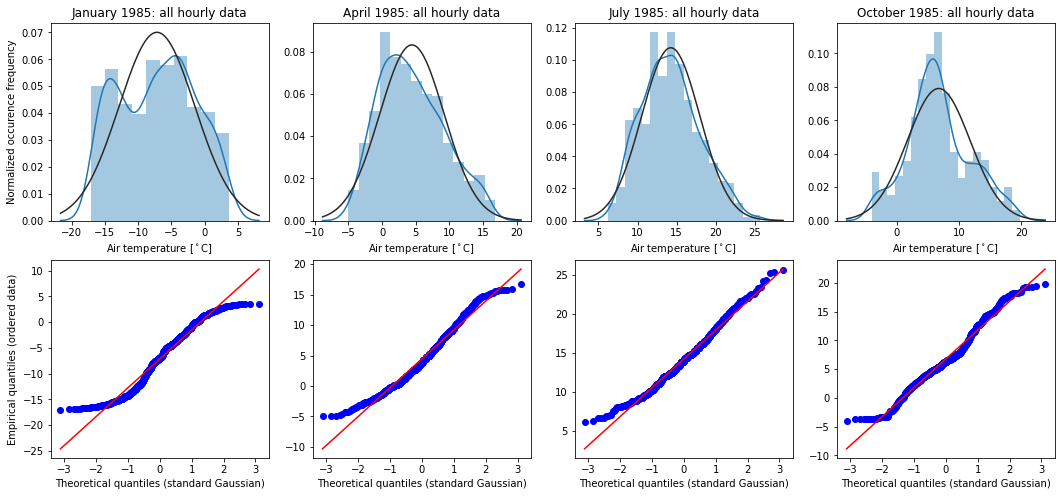

In [26]:
#.. arrays of selected months: numerical and string variables
MonthNumbers = [1,4,7,10]
MonthStrings = ['January','April','July','October']
#.. reference year
year = 1985
#.. open plot figure
plt.figure(figsize=(18,8))
#.. loop over selected months
for imonth in range(len(MonthNumbers)):
    #.. assign numerical month and string variable
    month = MonthNumbers[imonth]
    mname = MonthStrings[imonth]
    #.. load air temperature measurements, convert data matrix into a vector
    mat1d = DataYearMonth(AirTemp,year,month).reshape(-1)
    SampleMean = np.nanmean(mat1d)
    SampleStd = np.nanstd(mat1d,ddof=1)
    #.. compute and print monthly mean and std    
    print(mname+' {}, hourly air temperature data for the whole month'.format(year))
    print('* Monthly average +/- standard deviation : {:.2f} +/- {:.2f}'.format(\
        SampleMean,SampleStd))
    #.. perform Shapiro-Wilk test and print probability value
    TestStat,ProbVal = stats.shapiro(mat1d)
    print('* Shapiro-Wilk test, probability value   : {:.2e}\n'.format(ProbVal))
    #.. create subplot displaying empirical distributions
    plt.subplot(2,len(MonthNumbers),1+imonth)
    sns.distplot(mat1d,kde=True,fit=stats.norm)
    plt.title(mname+' {}'.format(year)+': all hourly data')
    plt.xlabel(r'Air temperature [$^\circ$C]')
    if imonth>0:
        plt.ylabel('')
    else:
        plt.ylabel('Normalized occurence frequency')
    #.. create subplot displaying the probability plot
    plt.subplot(2,len(MonthNumbers),5+imonth)
    stats.probplot(mat1d,plot=plt,fit=True)
    plt.title('')
    plt.xlabel('Theoretical quantiles (standard Gaussian)')
    if imonth>0:
        plt.ylabel('')
    else:
        plt.ylabel('Empirical quantiles (ordered data)')
#.. save figure to pdf
plt.savefig('dist_prob_'+StationID+'_{}_all.pdf'.format(year),\
            facecolor=None,bbox_inches='tight')

Construct confidence intervals for the (true) mean air temperature in a month using (1) normal theory statistics, (2) Student's $t$ distribution, and (3) the bootstrap approach to error estimation.

In [27]:
#.. parameters: confidence level gamma, significance level alpha
gamma = 0.95
alpha = 1 - gamma
#.. number of bootstrap samples
NumBS = 1000
#.. z-score for (1) confidence intervals from normal theory statistics
zscore = stats.norm.ppf(0.5*(1+gamma))
#.. loop over selected months
for imonth in range(len(MonthNumbers)):
    #.. assign numerical month and string variable
    month = MonthNumbers[imonth]
    mname = MonthStrings[imonth]
    #.. load air temperature measurements, convert data matrix into a vector
    mat1d = DataYearMonth(AirTemp,year,month).reshape(-1)
    #.. compute sample statistics
    SampleSize = mat1d.size
    SampleMean = np.nanmean(mat1d)
    SampleStd = np.nanstd(mat1d,ddof=1)
    #.. t-value for (2) confidence interval from Student's t distribution
    tvalue = stats.t.ppf(1-0.5*alpha,SampleSize-1)
    #.. confidence interval half-widths for (1) and (2)
    hwci_norm = zscore*SampleStd/np.sqrt(SampleSize)
    hwci_stud = tvalue*SampleStd/np.sqrt(SampleSize)
    #.. construct (3) bootstrap confidence intervals
    DiffMean = np.zeros(NumBS)  #.. array to store difference of sample means
    for isamp in range(0,NumBS):
        ind = np.random.choice(SampleSize,SampleSize)
        SampleMeanRes = np.nanmean(mat1d[ind])
        DiffMean[isamp] = SampleMeanRes - SampleMean
    DiffMeanSorted = np.sort(DiffMean)
    LowerInd = np.int(0.5*alpha*NumBS)
    UpperInd = np.int((1-0.5*alpha)*NumBS)
    #.. left and right confidence interval widths for (3)
    lwci_boot = DiffMeanSorted[UpperInd]
    rwci_boot = - DiffMeanSorted[LowerInd]
    #.. print confidence intervals
    print('Confidence intervals for the monthly mean temperature: '+mname+' {}'.format(year))
    print('* Normal theory : [{:.3f},{:.3f}]'.format(SampleMean-hwci_norm,SampleMean+hwci_norm))
    print("* Student's t   : [{:.3f},{:.3f}]".format(SampleMean-hwci_stud,SampleMean+hwci_stud))
    print('* Bootstrap     : [{:.3f},{:.3f}]\n'.format(SampleMean-lwci_boot,SampleMean+rwci_boot))

C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  year = np.int(TimeStr[0:4])
C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link fo

Confidence intervals for the monthly mean temperature: January 1985
* Normal theory : [-7.573,-6.754]
* Student's t   : [-7.574,-6.753]
* Bootstrap     : [-7.579,-6.738]

Confidence intervals for the monthly mean temperature: April 1985
* Normal theory : [4.084,4.785]
* Student's t   : [4.083,4.785]
* Bootstrap     : [4.126,4.755]

Confidence intervals for the monthly mean temperature: July 1985
* Normal theory : [13.974,14.507]
* Student's t   : [13.973,14.507]
* Bootstrap     : [13.972,14.495]

Confidence intervals for the monthly mean temperature: October 1985
* Normal theory : [6.395,7.121]
* Student's t   : [6.395,7.122]
* Bootstrap     : [6.393,7.083]



## Monthly distributions of air temperatures in the hour before noon 

Air temperature data for a particular time of the day can be conveniently extracted from the data matrix returned by the function ``DataYearMonth()``. Considering air temperatures in the hour before noon (hour before 12h, Python array index 11), repeat the analysis from the previous section.

C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  year = np.int(TimeStr[0:4])
C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link fo

January 1985, air temperature measurements in the hour before 12h
* Monthly average +/- standard deviation : -6.47 +/- 5.47
* Shapiro-Wilk test, probability value   : 2.60e-01

April 1985, air temperature measurements in the hour before 12h
* Monthly average +/- standard deviation : 6.57 +/- 5.20
* Shapiro-Wilk test, probability value   : 1.82e-01

July 1985, air temperature measurements in the hour before 12h
* Monthly average +/- standard deviation : 16.31 +/- 3.72
* Shapiro-Wilk test, probability value   : 3.39e-01



C:\Users\garma\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  year = np.int(TimeStr[0:4])
C:\Users\garma\AppData\Local\Temp/ipykernel_17388/293673

October 1985, air temperature measurements in the hour before 12h
* Monthly average +/- standard deviation : 8.77 +/- 5.11
* Shapiro-Wilk test, probability value   : 5.11e-02



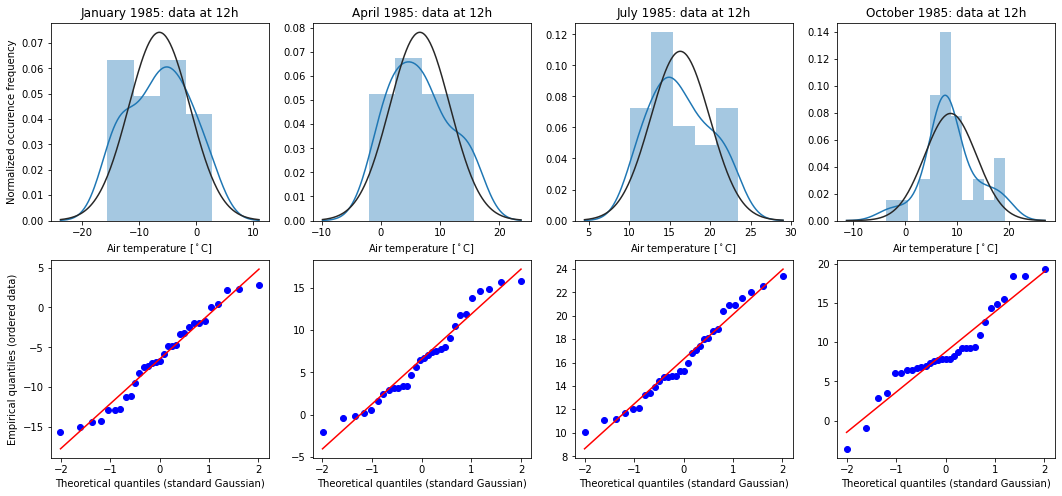

In [28]:
#.. daily hour of interest: set Python array index ihour
ihour = 11 
#.. open plot figure
plt.figure(figsize=(18,8))
#.. loop over selected months
for imonth in range(len(MonthNumbers)):
    #.. assign numerical month and string variable
    month = MonthNumbers[imonth]
    mname = MonthStrings[imonth]
    #.. load air temperature measurements for the chosen daily hour
    mat1d = DataYearMonth(AirTemp,year,month)[:,ihour]
    SampleMean = np.nanmean(mat1d)
    SampleStd = np.nanstd(mat1d,ddof=1)
    #.. compute and print monthly mean and std    
    print(mname+' {}, air temperature measurements in the hour before {}h'.format(year,ihour+1))
    print('* Monthly average +/- standard deviation : {:.2f} +/- {:.2f}'.format(\
            SampleMean,SampleStd))
    #.. perform Shapiro-Wilk test and print probability value
    TestStat,ProbVal = stats.shapiro(mat1d)
    print('* Shapiro-Wilk test, probability value   : {:.2e}\n'.format(ProbVal))
    #.. create subplot displaying empirical distributions
    plt.subplot(2,len(MonthNumbers),1+imonth)
    sns.distplot(mat1d,kde=True,fit=stats.norm)
    plt.title(mname+' {}'.format(year)+': data at {}h'.format(ihour+1))
    plt.xlabel(r'Air temperature [$^\circ$C]')
    if imonth>0:
        plt.ylabel('')
    else:
        plt.ylabel('Normalized occurence frequency')
    #.. create subplot displaying the probability plot    
    plt.subplot(2,len(MonthNumbers),5+imonth)
    stats.probplot(mat1d,plot=plt,fit=True)
    plt.title('')
    plt.xlabel('Theoretical quantiles (standard Gaussian)')
    if imonth>0:
        plt.ylabel('')
    else:
        plt.ylabel('Empirical quantiles (ordered data)')
#.. save figure to pdf
plt.savefig('dist_prob_'+StationID+'_{}_{}h.pdf'.format(year,ihour+1),\
            facecolor=None,bbox_inches='tight')

Construct confidence intervals for the (true) mean air temperature at noon using (1) normal theory statistics, (2) Student's $t$ distribution, and (3) the bootstrap approach to error estimation.

In [29]:
#.. z-score for (1) confidence intervals from normal theory statistics
zscore = stats.norm.ppf(1-0.5*alpha)
#.. loop over selected months
for imonth in range(len(MonthNumbers)):
    #.. assign numerical month and string variable
    month = MonthNumbers[imonth]
    mname = MonthStrings[imonth]
    #.. load air temperature measurements for the chosen daily hour
    mat1d = DataYearMonth(AirTemp,year,month)[:,ihour]
    #.. compute sample statistics
    SampleSize = mat1d.size
    SampleMean = np.nanmean(mat1d)
    SampleStd = np.nanstd(mat1d)
    #.. t-value for (2) confidence interval from Student's t distribution    
    tvalue = stats.t.ppf(1-0.5*alpha,SampleSize-1)
    #.. confidence interval half-widths for (1) and (2)
    hwci_norm = zscore*SampleStd/np.sqrt(SampleSize)
    hwci_stud = tvalue*SampleStd/np.sqrt(SampleSize)
    #.. construct (3) bootstrap confidence intervals
    DiffMean = np.zeros(NumBS)  #.. array to store difference of sample means
    for isamp in range(0,NumBS):
        ind = np.random.choice(SampleSize,SampleSize)
        SampleMeanRes = np.nanmean(mat1d[ind])
        DiffMean[isamp] = SampleMeanRes - SampleMean
    DiffMeanSorted = np.sort(DiffMean)
    LowerInd = np.int(0.5*alpha*NumBS)
    UpperInd = np.int((1-0.5*alpha)*NumBS)
    #.. left and right confidence interval widths for (3)
    lwci_boot = DiffMeanSorted[UpperInd]
    rwci_boot = - DiffMeanSorted[LowerInd]
    #.. print confidence intervals
    print('Confidence intervals for the mean temperature in the hour before {}h: '.format(ihour+1)\
          +mname+' {}'.format(year))
    print('* Normal theory : [{:.3f},{:.3f}]'.format(SampleMean-hwci_norm,SampleMean+hwci_norm))
    print("* Student's t   : [{:.3f},{:.3f}]".format(SampleMean-hwci_stud,SampleMean+hwci_stud))
    print('* Bootstrap     : [{:.3f},{:.3f}]\n'.format(SampleMean-lwci_boot,SampleMean+rwci_boot))

C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  year = np.int(TimeStr[0:4])
C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link fo

Confidence intervals for the mean temperature in the hour before 12h: January 1985
* Normal theory : [-8.364,-4.578]
* Student's t   : [-8.444,-4.498]
* Bootstrap     : [-8.474,-4.484]

Confidence intervals for the mean temperature in the hour before 12h: April 1985
* Normal theory : [4.745,8.402]
* Student's t   : [4.666,8.481]
* Bootstrap     : [4.773,8.263]

Confidence intervals for the mean temperature in the hour before 12h: July 1985
* Normal theory : [15.025,17.601]
* Student's t   : [14.971,17.655]
* Bootstrap     : [14.984,17.545]

Confidence intervals for the mean temperature in the hour before 12h: October 1985
* Normal theory : [6.998,10.537]
* Student's t   : [6.924,10.611]
* Bootstrap     : [6.923,10.587]



## Daily variation statistics of hourly air temperature data

The shape of the data matrix returned by the function ``DataYearMonth()`` facilitates the computation of daily variation statistics by applying operations along the first dimensions (``axis=0``). For the months January, April, 
July, and October in the reference year 1985, compute the mean $\overline{T}$ and the standard deviation $\Delta T$ separately for each daily hour (time $t$). Plot the daily variation of the mean $\overline{T} (t)$ on top of a filled region between $\overline{T} (t) - \Delta T (t)$ and $\overline{T} (t) + \Delta T (t)$ using the function ``fill_between()`` from the Python module ``matplotlib.pyplot``.

C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  year = np.int(TimeStr[0:4])
C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link fo

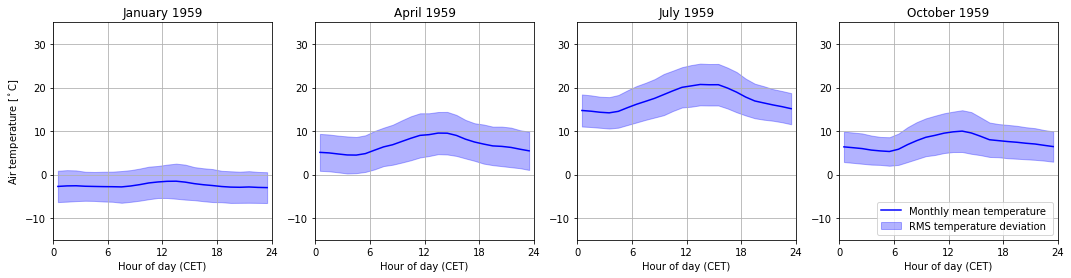

In [16]:
MonthNumbers = [1,4,7,10]
MonthStrings = ['January','April','July','October']
#.. air temperature plot range
atlim = [-15,35]
#.. hour of day array (centered)
hod = np.linspace(0.5,23.5,24)
#.. open plot figure
plt.figure(figsize=(18,4))
#.. loop over selected months
for imonth in range(len(MonthNumbers)):
    #.. assign numerical month and string variable
    month = MonthNumbers[imonth]
    mname = MonthStrings[imonth]
    #.. load air temperature measurements into data matrix
    mat2d = DataYearMonth(AirTemp,year,month)
    #.. compute daily variations statistics
    matmean = np.nanmean(mat2d,axis=0)
    matstd = np.nanstd(mat2d,axis=0,ddof=1)
    #.. create (sub)plot displaying daily variation mean and std
    plt.subplot(1,len(MonthNumbers),1+imonth)
    plt.plot(hod,matmean,color='blue',label='Monthly mean temperature')
    plt.fill_between(hod,matmean-matstd,matmean+matstd,\
                     color='blue',alpha=0.3,\
                     label='RMS temperature deviation ')
    plt.title(mname+' {}'.format(year))
    plt.xlabel(r'Hour of day (CET)')
    if imonth>0:
        plt.ylabel('')
    else:
        plt.ylabel(r'Air temperature [$^\circ$C]')
    plt.xlim([0,24])
    plt.xticks([0,6,12,18,24])
    plt.ylim(atlim)
    plt.grid()
    if imonth==(len(MonthNumbers)-1):
        plt.legend(loc=4)
#.. save figure to pdf
plt.savefig('daily_variations_'+StationID+'_{}.pdf'.format(year),\
            facecolor=None,bbox_inches='tight')

## Comparison of monthly temperature statistics on decadal time scales

For all months and each decade from 1950-1959 to 2010-2019, determine the average daily variations of air temperature at your observing station. For a particular month plot all seven decadally averaged curves into one panel, and combine all plots in a $(4 \times 3)$ diagram.

C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  year = np.int(TimeStr[0:4])
C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link fo

C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  year = np.int(TimeStr[0:4])
C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link fo

C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  year = np.int(TimeStr[0:4])
C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link fo

C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  year = np.int(TimeStr[0:4])
C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link fo

C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  year = np.int(TimeStr[0:4])
C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link fo

C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  year = np.int(TimeStr[0:4])
C:\Users\garma\AppData\Local\Temp/ipykernel_17388/2936731399.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link fo

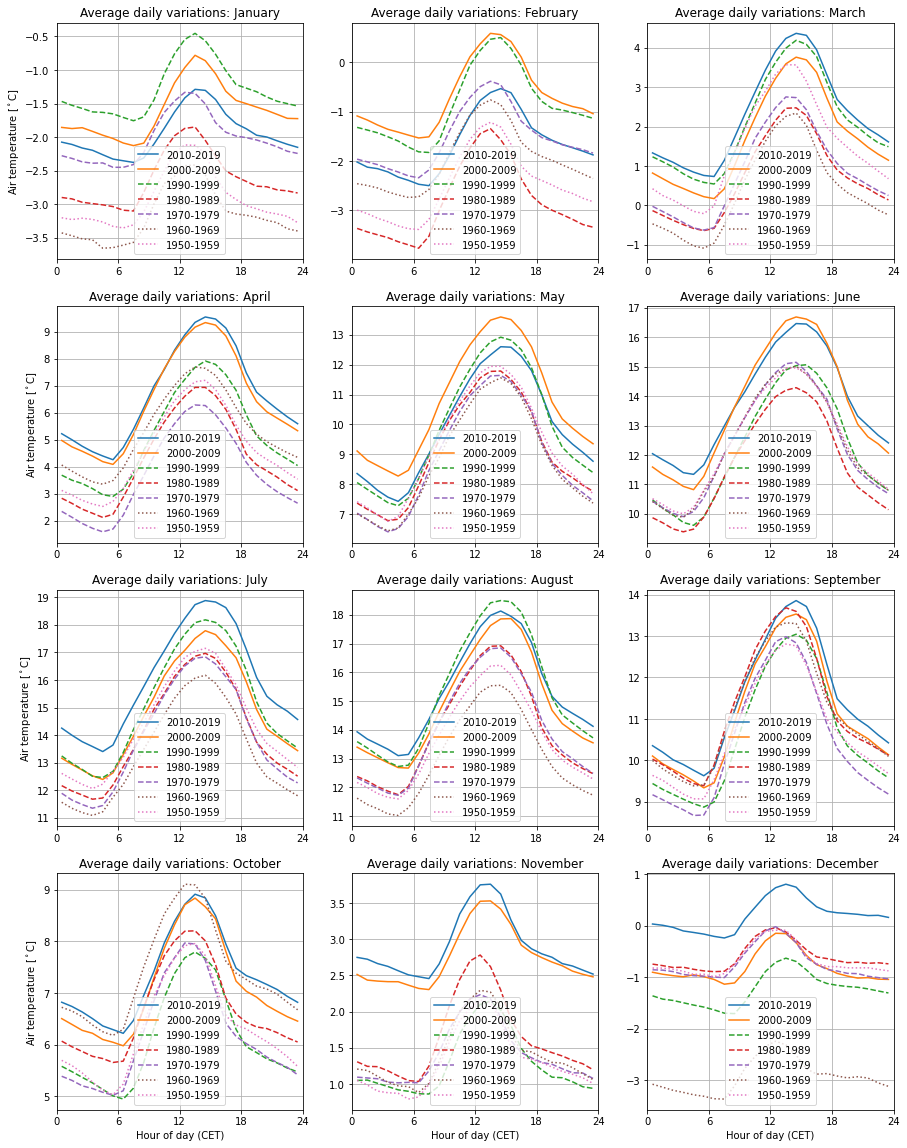

In [15]:
#.. arrays of selected months: numerical and string variables
MonthNumbers = [1,2,3,4,5,6,7,8,9,10,11,12]
MonthStrings = ['January','February','March','April','May','June',\
               'July','August','September','October','November','December']
#.. decadal averages: year array and plot parameters
YearArray = [2010,2000,1990,1980,1970,1960,1950]
LineStyleArray = 2*['-']+3*['--']+2*[':']
#.. open plot figure
plt.figure(figsize=(15,20))
#.. loop over selected months
for imonth in range(12):
    #.. assign numerical month and string variable
    month = MonthNumbers[imonth]
    mname = MonthStrings[imonth]
    #.. open subplot, title and x-axis annotation
    plt.subplot(4,3,imonth+1)
    plt.title('Average daily variations: '+mname)
    if imonth>8: plt.xlabel(r'Hour of day (CET)')
    plt.xlim([0,24])
    plt.xticks([0,6,12,18,24])
    #.. y-axis annotation
    if imonth%3==0:
        plt.ylabel(r'Air temperature [$^\circ$C]')
    #.. loop over decades
    for iyear in range(len(YearArray)):
        #.. set initial year
        year = YearArray[iyear]
        #.. load data and compute average daily variations
        mat1d = np.nanmean(DataYearMonth(AirTemp,year,month),axis=0)
        #.. loop over remaining years in decade
        for k in range(9):
            year = year+1
            #.. accumulate average daily variations
            mat1d = mat1d + np.nanmean(DataYearMonth(AirTemp,year,month),axis=0)
        #.. compute decadal average of daily variations 
        mat1d = 0.1*mat1d
        #.. plot decadally averaged daily variations
        plt.plot(hod,mat1d,label='{}-{}'.format(YearArray[iyear],year),\
                ls=LineStyleArray[iyear])
    plt.grid()
    plt.legend(loc=8)
#.. save figure to pdf
plt.savefig('daily_variations_decadal_'+StationID+'.pdf',\
            facecolor=None,bbox_inches='tight')